# Bike Conversion Analysis

We are given a task by our boss to figure out how we can turn our casual cyclist into a yearly subscription cyclist. The company itself have two different kinds of cyclist: the casual one's and a yearly subscription cycylist. We have found out that the yearly subscription cyclist actually gives us more profit, so we are looking for a way to convert our casual cyclist into a subscription cyclist. To Do this, our superior has tasked us to figure out the difference in behaviour of casual and subscription cyclist and to give recommendation on what the company should do

## Import needed Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Initial Data Exploration

Now we are going to load and take a look on our data that we got from the data engineering team, they are so nice to give us the data in a csv format

In [2]:
data1 = pd.read_csv("202305-divvy-tripdata.csv", engine='python', on_bad_lines='skip')
data1.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,0D9FA920C3062031,electric_bike,2023-05-07 19:53:48,2023-05-07 19:58:32,Southport Ave & Belmont Ave,13229,NaN,NaN,41.939408,-87.663831,41.930000,-87.650000,member
1,92485E5FB5888ACD,electric_bike,2023-05-06 18:54:08,2023-05-06 19:03:35,Southport Ave & Belmont Ave,13229,NaN,NaN,41.939482,-87.663848,41.940000,-87.690000,member
2,FB144B3FC8300187,electric_bike,2023-05-21 00:40:21,2023-05-21 00:44:36,Halsted St & 21st St,13162,NaN,NaN,41.853793,-87.646719,41.860000,-87.650000,member
3,DDEB93BC2CE9AA77,classic_bike,2023-05-10 16:47:01,2023-05-10 16:59:52,Carpenter St & Huron St,13196,Damen Ave & Cortland St,13133,41.894556,-87.653449,41.915983,-87.677335,member
4,C07B70172FC92F59,classic_bike,2023-05-09 18:30:34,2023-05-09 18:39:28,Southport Ave & Clark St,TA1308000047,Southport Ave & Belmont Ave,13229,41.957081,-87.664199,41.939478,-87.663748,member


In [3]:
data1.shape

(310309, 13)

In [4]:
data_column = data1.columns
data_column

Index(['ride_id', 'rideable_type', 'started_at', 'ended_at',
       'start_station_name', 'start_station_id', 'end_station_name',
       'end_station_id', 'start_lat', 'start_lng', 'end_lat', 'end_lng',
       'member_casual'],
      dtype='object')

Lets take a look on our unique values

In [5]:
# lets get rid of the start_lat etc, since we are going to see the unique values and those columns are numerical
unique_value_column = ['rideable_type','start_station_id', 'end_station_id', 'member_casual']
unique_value_data = {}
for column in unique_value_column:
  print(f"Column {column} Unique values: {data1[column].unique()}")
  unique_value_data[column] = data1[column].unique()

Column rideable_type Unique values: ['electric_bike' 'classic_bike' 'docked_bike']
Column start_station_id Unique values: ['13229' '13162' '13196' ... '566' '1095.0' '1232.0']
Column end_station_id Unique values: [nan '13133' '13229' ... '1265.0' '1232.0' '1239.0']
Column member_casual Unique values: ['member' 'casual']


Now lets prep our data, we are going to do a bit of data processing. Lets start by finding out how many missing values we have

In [6]:
data1.isna().sum()

ride_id                   0
rideable_type             0
started_at                0
ended_at                  0
start_station_name    26758
start_station_id      26758
end_station_name      14495
end_station_id        14495
start_lat                 0
start_lng                 0
end_lat                 193
end_lng                 193
member_casual             0
dtype: int64

In [7]:
# a quick check whether the month is all the same before dropping null values
# data1['started_at'].astype('datetime64[ns]').dt.month_name().unique()

array(['May'], dtype=object)

In [8]:
data1.shape

(310309, 13)

There are quite a number of missing values, lets try to get rid of it and see how many rows we have left

In [9]:
data2 = data1.dropna()
data2.shape

(269364, 13)

quite a bit data got dropped, But I don't think we can impute values into the data because the missing values are from location data like start_station, location_coordinates, etc

In [10]:
data2.isna().sum()

ride_id               0
rideable_type         0
started_at            0
ended_at              0
start_station_name    0
start_station_id      0
end_station_name      0
end_station_id        0
start_lat             0
start_lng             0
end_lat               0
end_lng               0
member_casual         0
dtype: int64

Now lets check if there are ride_id that have duplicates, This shouldn't happen, but if there are, we should get rid of it

In [12]:
duplicates = data2[data2['ride_id'].duplicated()]
duplicates.sum()

ride_id                 0
rideable_type           0
started_at              0
ended_at                0
start_station_name      0
start_station_id        0
end_station_name        0
end_station_id          0
start_lat             0.0
start_lng             0.0
end_lat               0.0
end_lng               0.0
member_casual           0
dtype: object

Good to know there aren't any duplicated id, so it is probably safe to go into the next step

## Data Manipulation

First of all lets create another column that gives us the information on what day our rides are typically done, we also would like to know the duration of the ride.

lets first of all get the duration

In [13]:
duration = data2['ended_at'].astype('datetime64[ns]') - data2['started_at'].astype('datetime64[ns]')
duration = duration.dt.total_seconds().div(60).astype(int)
duration

3         12
4          8
5         15
6         33
7          4
          ..
310304    16
310305    19
310306    25
310307     6
310308    15
Length: 269364, dtype: int64

In [14]:
data2['ride_duration_minutes'] = duration
data2.head()

<ipython-input-14-10cf91b1837d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2['ride_duration_minutes'] = duration


,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,ride_duration_minutes
3,DDEB93BC2CE9AA77,classic_bike,2023-05-10 16:47:01,2023-05-10 16:59:52,Carpenter St & Huron St,13196,Damen Ave & Cortland St,13133,41.894556,-87.653449,41.915983,-87.677335,member,12
4,C07B70172FC92F59,classic_bike,2023-05-09 18:30:34,2023-05-09 18:39:28,Southport Ave & Clark St,TA1308000047,Southport Ave & Belmont Ave,13229,41.957081,-87.664199,41.939478,-87.663748,member,8
5,2BA66385DF8F815A,classic_bike,2023-05-30 15:01:21,2023-05-30 15:17:00,Clinton St & Madison St,TA1305000032,McClurg Ct & Ohio St,TA1306000029,41.882752,-87.641190,41.892592,-87.617289,member,15
6,31EFCCB05F12D8EF,docked_bike,2023-05-09 14:13:40,2023-05-09 14:47:20,DuSable Lake Shore Dr & Monroe St,13300,Adler Planetarium,13431,41.880958,-87.616743,41.866095,-87.607267,casual,33
7,71DFF834E1D3CE0B,classic_bike,2023-05-06 16:47:22,2023-05-06 16:52:13,Shore Dr & 55th St,TA1308000009,Harper Ave & 59th St,KA1503000070,41.795212,-87.580715,41.787943,-87.588315,member,4


Now lets try to get the day of our ride, lets use the started_at column to figure this out

In [15]:
data2.loc[:, 'day_of_ride']= data2['started_at'].astype('datetime64[ns]').dt.day_name()

<ipython-input-15-3891d4ab7078>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2.loc[:, 'day_of_ride']= data2['started_at'].astype('datetime64[ns]').dt.day_name()


In [16]:
data2.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,ride_duration_minutes,day_of_ride
3,DDEB93BC2CE9AA77,classic_bike,2023-05-10 16:47:01,2023-05-10 16:59:52,Carpenter St & Huron St,13196,Damen Ave & Cortland St,13133,41.894556,-87.653449,41.915983,-87.677335,member,12,Wednesday
4,C07B70172FC92F59,classic_bike,2023-05-09 18:30:34,2023-05-09 18:39:28,Southport Ave & Clark St,TA1308000047,Southport Ave & Belmont Ave,13229,41.957081,-87.664199,41.939478,-87.663748,member,8,Tuesday
5,2BA66385DF8F815A,classic_bike,2023-05-30 15:01:21,2023-05-30 15:17:00,Clinton St & Madison St,TA1305000032,McClurg Ct & Ohio St,TA1306000029,41.882752,-87.641190,41.892592,-87.617289,member,15,Tuesday
6,31EFCCB05F12D8EF,docked_bike,2023-05-09 14:13:40,2023-05-09 14:47:20,DuSable Lake Shore Dr & Monroe St,13300,Adler Planetarium,13431,41.880958,-87.616743,41.866095,-87.607267,casual,33,Tuesday
7,71DFF834E1D3CE0B,classic_bike,2023-05-06 16:47:22,2023-05-06 16:52:13,Shore Dr & 55th St,TA1308000009,Harper Ave & 59th St,KA1503000070,41.795212,-87.580715,41.787943,-87.588315,member,4,Saturday


Lets also try to get the month and season of the bike ride

In [17]:
# get the month
month_data = data2['started_at'].astype('datetime64[ns]').dt.month_name()
data2.insert(15, 'ride_month', month_data)
data2.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,ride_duration_minutes,day_of_ride,ride_month
3,DDEB93BC2CE9AA77,classic_bike,2023-05-10 16:47:01,2023-05-10 16:59:52,Carpenter St & Huron St,13196,Damen Ave & Cortland St,13133,41.894556,-87.653449,41.915983,-87.677335,member,12,Wednesday,May
4,C07B70172FC92F59,classic_bike,2023-05-09 18:30:34,2023-05-09 18:39:28,Southport Ave & Clark St,TA1308000047,Southport Ave & Belmont Ave,13229,41.957081,-87.664199,41.939478,-87.663748,member,8,Tuesday,May
5,2BA66385DF8F815A,classic_bike,2023-05-30 15:01:21,2023-05-30 15:17:00,Clinton St & Madison St,TA1305000032,McClurg Ct & Ohio St,TA1306000029,41.882752,-87.641190,41.892592,-87.617289,member,15,Tuesday,May
6,31EFCCB05F12D8EF,docked_bike,2023-05-09 14:13:40,2023-05-09 14:47:20,DuSable Lake Shore Dr & Monroe St,13300,Adler Planetarium,13431,41.880958,-87.616743,41.866095,-87.607267,casual,33,Tuesday,May
7,71DFF834E1D3CE0B,classic_bike,2023-05-06 16:47:22,2023-05-06 16:52:13,Shore Dr & 55th St,TA1308000009,Harper Ave & 59th St,KA1503000070,41.795212,-87.580715,41.787943,-87.588315,member,4,Saturday,May


In [18]:
# lets see month's unique value
data2['ride_month'].unique()

array(['May'], dtype=object)

Looks like there is only May, So we can't get any insight from the changing seasons or month

In [19]:
data2['ride_id'].nunique()

269364

Ride Id represents the ride id and not the member id, so we can't take any insights from that one

# Data Analysis

Lets now do some analysis to our data, first of all, we are going to drop data that we won't need

In [20]:
data3 = data2.drop(axis=1, columns=['ride_id','started_at','ended_at','start_station_name','start_station_id','end_station_name','end_station_id','start_lat','start_lng','end_lat','end_lng'])

In [21]:
data3.head()

,rideable_type,member_casual,ride_duration_minutes,day_of_ride,ride_month
3,classic_bike,member,12,Wednesday,May
4,classic_bike,member,8,Tuesday,May
5,classic_bike,member,15,Tuesday,May
6,docked_bike,casual,33,Tuesday,May
7,classic_bike,member,4,Saturday,May


Lets split our data based on our member

In [22]:
filter1 = data3['member_casual'] == 'casual'
filter2 = data3['member_casual'] == 'member'
casual_member = data3.where(filter1).dropna()
subscription_member = data3.where(filter2).dropna()

In [23]:
print(casual_member.shape)
casual_member.head()

(101562, 5)


,rideable_type,member_casual,ride_duration_minutes,day_of_ride,ride_month
6,docked_bike,casual,33.0,Tuesday,May
14,electric_bike,casual,31.0,Saturday,May
15,electric_bike,casual,20.0,Monday,May
17,docked_bike,casual,161.0,Sunday,May
25,docked_bike,casual,27.0,Saturday,May


In [24]:
print(subscription_member.shape)
subscription_member.head()

(167802, 5)


,rideable_type,member_casual,ride_duration_minutes,day_of_ride,ride_month
3,classic_bike,member,12.0,Wednesday,May
4,classic_bike,member,8.0,Tuesday,May
5,classic_bike,member,15.0,Tuesday,May
7,classic_bike,member,4.0,Saturday,May
8,classic_bike,member,12.0,Monday,May


## Lets create ourselves some pivot tables to get insight on our data

#### Ride Duration By bike types

In [25]:
subscription_member.groupby(['rideable_type']).aggregate({'ride_duration_minutes': 'mean'})

,ride_duration_minutes
rideable_type,
classic_bike,13.337229
electric_bike,10.479041


In [26]:
casual_member.groupby(['rideable_type']).aggregate({'ride_duration_minutes': 'mean'})

,ride_duration_minutes
rideable_type,
classic_bike,27.078487
docked_bike,53.568896
electric_bike,15.774934


Casual member actually rides bike more often, we might be able to target the benefits of having a subscription than casual in terms of discount or such

### Day of Ride and Duration

First we are going to sort our days from monday to sunday. If we don't do this, the groupby day_of_ride will not be sorted. To do this, we create a categorical column that is ordered and we put it into our dataframe

In [27]:
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

In [28]:
subscription_member['day_of_ride'] = pd.Categorical(subscription_member['day_of_ride'], categories=days_order, ordered=True)
casual_member['day_of_ride'] = pd.Categorical(casual_member['day_of_ride'], categories=days_order, ordered=True)

In [33]:
sub_member = subscription_member.sort_values(['day_of_ride']).groupby(['day_of_ride']).aggregate({'ride_duration_minutes': 'mean', 'member_casual': 'count'})
sub_member

,ride_duration_minutes,member_casual
day_of_ride,,
Monday,11.617485,22305
Tuesday,11.925081,31434
Wednesday,11.599557,30721
Thursday,11.690869,25507
Friday,11.616654,20608
Saturday,13.836235,18899
Sunday,14.412647,18328


In [34]:
ride_casual = casual_member.sort_values(['day_of_ride']).groupby(['day_of_ride']).aggregate({'ride_duration_minutes': 'mean', 'member_casual': 'count'})
ride_casual

,ride_duration_minutes,member_casual
day_of_ride,,
Monday,25.783323,12724
Tuesday,22.527002,14258
Wednesday,20.762059,13310
Thursday,21.279669,12100
Friday,22.281288,12297
Saturday,27.719262,17885
Sunday,28.686750,18988


#### Lets see the mean, etc of our data

In [31]:
casual_member.describe(include='all')

,rideable_type,member_casual,ride_duration_minutes,day_of_ride,ride_month
count,101562,101562,101562.000000,101562,101562
unique,3,1,NaN,7,1
top,classic_bike,casual,NaN,Sunday,May
freq,52620,101562,NaN,18988,101562
mean,NaN,NaN,24.591284,NaN,NaN
std,NaN,NaN,62.979131,NaN,NaN
min,NaN,NaN,0.000000,NaN,NaN
25%,NaN,NaN,7.000000,NaN,NaN
50%,NaN,NaN,14.000000,NaN,NaN
75%,NaN,NaN,27.000000,NaN,NaN


In [32]:
subscription_member.describe(include='all')

,rideable_type,member_casual,ride_duration_minutes,day_of_ride,ride_month
count,167802,167802,167802.000000,167802,167802
unique,2,1,NaN,7,1
top,classic_bike,member,NaN,Tuesday,May
freq,103271,167802,NaN,31434,167802
mean,NaN,NaN,12.238066,NaN,NaN
std,NaN,NaN,21.116509,NaN,NaN
min,NaN,NaN,0.000000,NaN,NaN
25%,NaN,NaN,5.000000,NaN,NaN
50%,NaN,NaN,9.000000,NaN,NaN
75%,NaN,NaN,15.000000,NaN,NaN


## Data Visualization

Lets create a visualization to better see our data distribution

In [44]:
plot_ride_casual = ride_casual.reset_index()
plot_ride_casual

,day_of_ride,ride_duration_minutes,member_casual
0,Monday,25.783323,12724
1,Tuesday,22.527002,14258
2,Wednesday,20.762059,13310
3,Thursday,21.279669,12100
4,Friday,22.281288,12297
5,Saturday,27.719262,17885
6,Sunday,28.686750,18988


In [46]:
plot_ride_member = sub_member.reset_index()
plot_ride_member

,day_of_ride,ride_duration_minutes,member_casual
0,Monday,11.617485,22305
1,Tuesday,11.925081,31434
2,Wednesday,11.599557,30721
3,Thursday,11.690869,25507
4,Friday,11.616654,20608
5,Saturday,13.836235,18899
6,Sunday,14.412647,18328


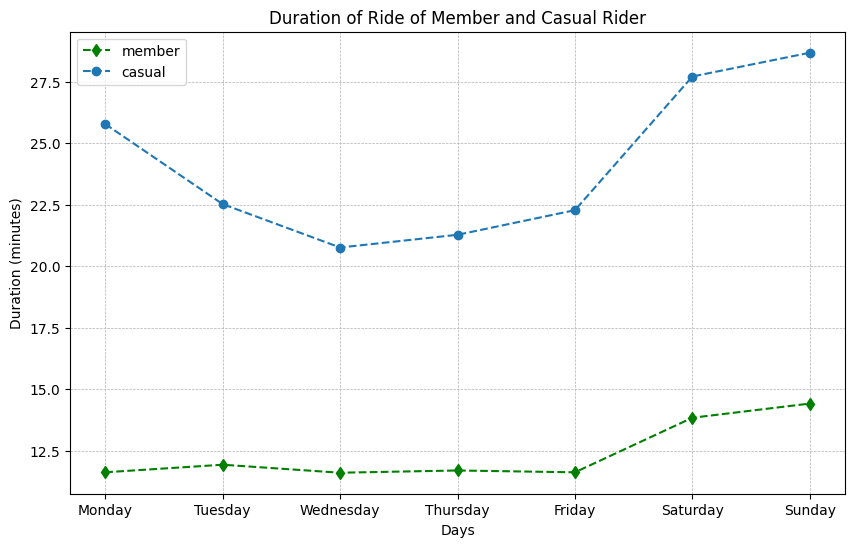

In [55]:
plt.figure(figsize=(10, 6))

x = plot_ride_member['day_of_ride']

x_axis = np.arange(len(x))

plt.plot(x, plot_ride_member['ride_duration_minutes'], label='member', ls='dashed', marker='d', c='green')
plt.plot(x, plot_ride_casual['ride_duration_minutes'], label='casual', ls='dashed', marker='o')

plt.grid(linestyle='--', linewidth=0.5)

plt.xticks(x_axis, x)
plt.xlabel('Days')
plt.ylabel('Duration (minutes)')
plt.title("Duration of Ride of Member and Casual Rider")
plt.legend()

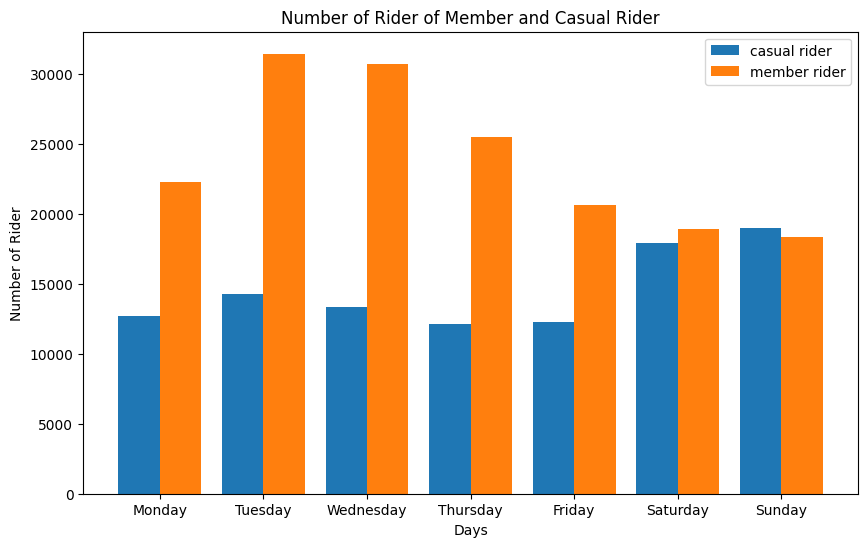

In [50]:
plt.figure(figsize=(10, 6))

x = plot_ride_casual['day_of_ride']

x_axis = np.arange(len(x))

plt.bar(x_axis - 0.2, plot_ride_casual['member_casual'], 0.4, label='casual rider')
plt.bar(x_axis + 0.2, plot_ride_member['member_casual'], 0.4, label='member rider')

plt.xticks(x_axis, x)
plt.xlabel('Days')
plt.ylabel('Number of Rider')
plt.title("Number of Rider of Member and Casual Rider")
plt.legend()
plt.show()

In [63]:
bike_type_member = subscription_member.groupby(['rideable_type']).aggregate({'ride_duration_minutes': 'mean'}).reset_index()
bike_type_casual = casual_member.groupby(['rideable_type']).aggregate({'ride_duration_minutes': 'mean'}).reset_index()

In [64]:
bike_type_member

,rideable_type,ride_duration_minutes
0,classic_bike,13.337229
1,electric_bike,10.479041


<Figure size 1000x600 with 0 Axes>

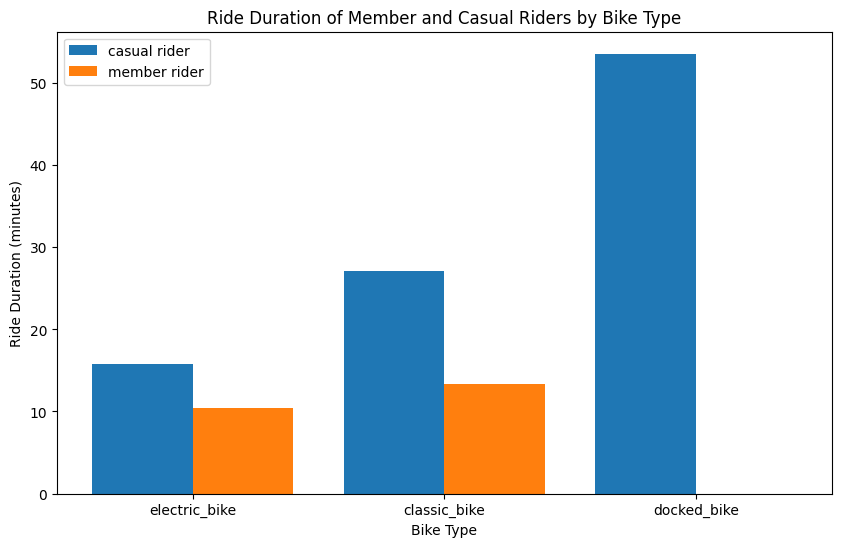

In [67]:
plt.figure(figsize=(10, 6))

expected_bike_types = ['electric_bike', 'classic_bike', 'docked_bike']

# Ensure bike_type_casual and bike_type_member have the expected bike types
bike_type_casual = bike_type_casual.set_index('rideable_type').reindex(expected_bike_types, fill_value=0).reset_index()
bike_type_member = bike_type_member.set_index('rideable_type').reindex(expected_bike_types, fill_value=0).reset_index()

plt.figure(figsize=(10, 6))

x = bike_type_member['rideable_type']
x_axis = np.arange(len(x))

plt.bar(x_axis - 0.2, bike_type_casual['ride_duration_minutes'], 0.4, label='casual rider')
plt.bar(x_axis + 0.2, bike_type_member['ride_duration_minutes'], 0.4, label='member rider')

plt.xticks(x_axis, x)
plt.xlabel('Bike Type')
plt.ylabel('Ride Duration (minutes)')
plt.title("Ride Duration of Member and Casual Riders by Bike Type")
plt.legend()
plt.show()

In [80]:
bike_type_member_count = subscription_member.groupby(['rideable_type']).aggregate({'member_casual': 'count'}).reset_index()
bike_type_casual_count = casual_member.groupby(['rideable_type']).aggregate({'member_casual': 'count'}).reset_index()

In [82]:
bike_type_member_count

,rideable_type,member_casual
0,classic_bike,103271
1,electric_bike,64531


In [83]:
bike_type_casual_count

,rideable_type,member_casual
0,classic_bike,52620
1,docked_bike,7954
2,electric_bike,40988


In [92]:
electric_bike_ratio_member = bike_type_member_count[bike_type_member_count['rideable_type']=='electric_bike']['member_casual']/bike_type_member_count['member_casual'].sum()
electric_bike_ratio_casual = bike_type_casual_count[bike_type_casual_count['rideable_type']=='electric_bike']['member_casual']/bike_type_casual_count['member_casual'].sum()
print(f"{electric_bike_ratio_member.values[0]}|{electric_bike_ratio_casual.values[0]}")

0.38456633413189356|0.4035761406825387


In [93]:
classic_bike_ratio_member = bike_type_member_count[bike_type_member_count['rideable_type']=='classic_bike']['member_casual']/bike_type_member_count['member_casual'].sum()
classic_bike_ratio_casual = bike_type_casual_count[bike_type_casual_count['rideable_type']=='classic_bike']['member_casual']/bike_type_casual_count['member_casual'].sum()
print(f"{classic_bike_ratio_member.values[0]}|{classic_bike_ratio_casual.values[0]}")

0.6154336658681064|0.5181071660660483


In [74]:
# Some statistics to help us create the summary

# Casual riders rides our bike 2 times more on average than member
print(f"{plot_ride_casual['ride_duration_minutes'].mean()/plot_ride_member['ride_duration_minutes'].mean()}")

# Rate of which people use our bike, member tends to ride our bikes more but with shorter duration
print(f"{plot_ride_member['member_casual'].sum()/plot_ride_casual['member_casual'].sum()}")

# Casual Member rides our electric bike more (a tad bit more) than our Sub member
# Sub Member rides our classical bike more (quite a bit more) than our casual member
# Only casual member can ride the docked bike

1.9497372827711883
1.6522124416612514


The Summary of our data Analysis
1. Casual rider on average rides our bikes for longer time, it is about 2 times as long as our member rider
2. Member tends to ride our bikes for a shorter duration but they like to ride our bikes more
3. Casual Member rides our electric bikes more than our sub member. But sub member rides our classical bikes more than our casual member
4. Casual Member and sub member likes to ride our classical bike than our electric bike
